In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from milk.eager import MilkEager
from milk.encoder_config import mnist_args

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def rearrange_bagged_mnist(x, y, positive_label):
    """
    For simplicity, rearrange the mnist digits from
    x ~ all classes 
    
    into

    x_pos ~ positive class(es)
    x_neg ~ positive class(es)
    """
    positive_mask = y == positive_label
    negative_mask = y != positive_label
    x_pos = x[positive_mask, ...] / 255. - 0.5
    x_neg = x[negative_mask, ...] / 255. - 0.5

    return x_pos, x_neg
  
def generate_negative_bag(x_neg, N):
    n_x_neg = x_neg.shape[0]
    neg_indices = np.random.choice(range(n_x_neg), N, replace=False)
    xbag = x_neg[neg_indices,...]
    np.random.shuffle(xbag)

    return xbag
  
def generate_positive_bag(x_pos, x_neg, N):
    n_x_pos = x_pos.shape[0]
    n_pos = int(np.random.uniform(low=1, high=int(N * 0.2)))
    # print('Generating bag with {} positive instances'.format(n_pos))
    pos_indices = np.random.choice(range(n_x_pos), n_pos, replace=False)
    xbag = [x_pos[pos_indices,...]]

    n_neg = N - n_pos
    xbag.append(generate_negative_bag(x_neg, n_neg))

    xbag = np.concatenate(xbag, axis=0)
    np.random.shuffle(xbag)
    return xbag

def generate_bagged_mnist(x_pos, x_neg, N, batch):
    """
    x ~ (samples, h, w)
    y ~ (samples)
    N ~ int. the size of the bag 

    return:
    bag_x ~ (1, N, h, w, (c))
    bag_y ~ (1, 2)
    """
    # Coin flip for generating a positive or negative bag:
    while True:
        batch_x, batch_y = [], []
        for _ in range(batch):
            y = np.random.choice([0,1])
            y_onehot = np.zeros((1,2), dtype=np.float32)
            y_onehot[0,y] = 1

            if y == 0:
                xbag = generate_negative_bag(x_neg, N)
                xbag = np.expand_dims(xbag, axis=0)
                xbag = np.expand_dims(xbag, axis=-1)
            else:
                xbag = generate_positive_bag(x_pos, x_neg, N)
                xbag = np.expand_dims(xbag, axis=0)
                xbag = np.expand_dims(xbag, axis=-1)

            batch_x.append(xbag.astype(np.float32))
            batch_y.append(y_onehot)

        yield np.concatenate(batch_x, axis=0), np.concatenate(batch_y, axis=0)

def generate_batch(x, y, N):
    while True:
        n_x = x.shape[0]
        idx = np.random.choice(range(n_x), N)

        batch_x = x[idx, ...] / 255. - 0.5
        batch_y = np.eye(N, 10)[y[idx]]

        yield np.expand_dims(batch_x, -1).astype(np.float32), batch_y

In [3]:
batch_size = 8
bag_size = 25

model = MilkEager(z_dim=128, 
                  mil_type='attention',
                  encoder_args=mnist_args,
                  deep_classifier=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

(train_x, train_y), (test_x, test_y) = mnist.load_data()
positive_label = np.random.choice(range(10))
print('using positive label = {}'.format(positive_label))

train_x_pos, train_x_neg = rearrange_bagged_mnist(train_x, train_y, positive_label)
test_x_pos, test_x_neg = rearrange_bagged_mnist(test_x, test_y, positive_label)

generator = generate_bagged_mnist(train_x_pos, train_x_neg,   bag_size, batch_size)
val_generator = generate_bagged_mnist(test_x_pos, test_x_neg, bag_size, batch_size)

Instantiating a DenseNet with settings:
	depth_of_model           : 16
	growth_rate              : 24
	num_of_blocks            : 2
	num_layers_in_each_block : 8
	dropout_rate             : 0.3
	mcdropout                : False
	pool_initial             : True
using positive label = 5


In [4]:
x_batch, y_batch = next(generator)
ypred = model(tf.constant(x_batch), verbose=True)

(8, 25, 28, 28, 1)
Encoder Call:
n_x:  8
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)
z: (1, 312)
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)
z: (1, 312)
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)
z: (1, 312)
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)
z: (1, 312)
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)
z: (1, 312)
x_bag: (1, 25, 28, 28, 1)
	 z:  (25, 312)
	z bag: (25, 312)
attention: (25, 256)
attention: (1, 25)
attention: (1, 25)
features - attention: (1, 312)

In [5]:
iterations = 500
epochs = 20
avglosses = []
for e in range(epochs):
    x_batch, y_batch = next(val_generator)
    ypred = model(tf.constant(x_batch), training=False)
    loss = tf.keras.losses.categorical_crossentropy(y_true=y_batch, y_pred=ypred)
    print('epoch {:02d}: loss={:3.5f}'.format(e, np.mean(loss)))
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            x_batch, y_batch = next(generator)
            y_batch = tf.constant(y_batch, tf.float32)
            ypred = model(tf.constant(x_batch))
            loss = tf.keras.losses.categorical_crossentropy(y_true=y_batch, y_pred=ypred)
            avglosses.append(np.mean(loss))
            
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))
        
        if i % 100 == 0:
            print('\tstep {:03d}: loss={:3.5f}'.format(i, np.mean(avglosses)))
            avglosses = []

epoch 00: loss=0.68977
	step 000: loss=0.70224
	step 100: loss=0.69527
	step 200: loss=0.69544
	step 300: loss=0.69391
	step 400: loss=0.69356
epoch 01: loss=0.69373
	step 000: loss=0.69431
	step 100: loss=0.69126
	step 200: loss=0.69364
	step 300: loss=0.69424
	step 400: loss=0.69393
epoch 02: loss=0.68829
	step 000: loss=0.69414
	step 100: loss=0.69345
	step 200: loss=0.69504
	step 300: loss=0.69367
	step 400: loss=0.69365
epoch 03: loss=0.68797
	step 000: loss=0.69300
	step 100: loss=0.69063
	step 200: loss=0.36175
	step 300: loss=0.17832
	step 400: loss=0.16064
epoch 04: loss=0.36016
	step 000: loss=0.17318
	step 100: loss=0.18365


KeyboardInterrupt: 

(100, 28, 28, 1)
	 z:  (64, 312)
	 z:  (36, 312)
	z bag: (100, 312)
attention: (100, 256)
attention: (1, 100)
attention: (1, 100)
features - attention: (1, 312)


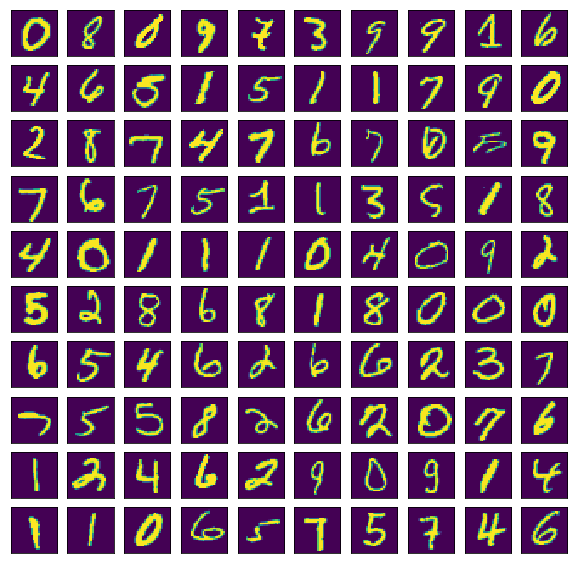

<Figure size 432x288 with 0 Axes>

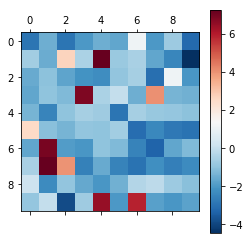

In [14]:
x_bag = generate_positive_bag(train_x_pos, train_x_neg, 100)
# x_bag = np.expand_dims(x_bag, axis=0)
x_bag = np.expand_dims(x_bag, axis=-1)
print(x_bag.shape)
features = model.encode_bag(tf.constant(x_bag, dtype=tf.float32), training=False, return_z=True, verbose=True)
features_att, att = model.mil_attention(features, return_raw_att=True, verbose=True)
ypred = model.apply_classifier(features_att)

att = att.numpy()

fig, axs = plt.subplots(10,10, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.matshow(np.squeeze(x_bag[i,...]))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
fig = plt.figure()
plt.matshow(att.reshape(10,10), cmap='RdBu_r')
plt.colorbar()

(100, 28, 28, 1)
	 z:  (64, 312)
	 z:  (36, 312)
	z bag: (100, 312)
attention: (100, 256)
attention: (1, 100)
attention: (1, 100)
features - attention: (1, 312)


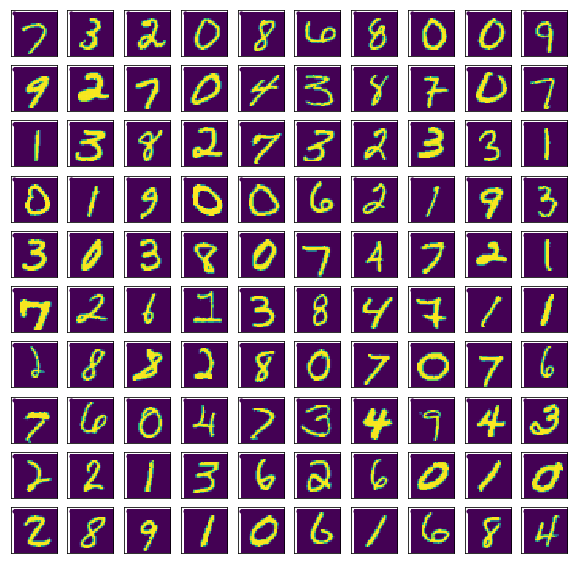

<Figure size 432x288 with 0 Axes>

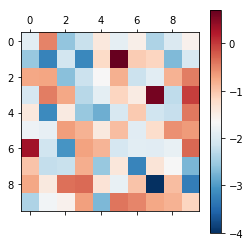

In [13]:
x_bag = generate_negative_bag(train_x_neg, 100)
# x_bag = np.expand_dims(x_bag, axis=0)
x_bag = np.expand_dims(x_bag, axis=-1)
print(x_bag.shape)
features = model.encode_bag(tf.constant(x_bag, dtype=tf.float32), training=False, return_z=True, verbose=True)
features_att, att = model.mil_attention(features, return_raw_att=True, verbose=True)
ypred = model.apply_classifier(features_att)

att = att.numpy()

fig, axs = plt.subplots(10,10, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.matshow(np.squeeze(x_bag[i,...]))
    ax.scatter(0,0, c=att[0,i], s=10)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
fig = plt.figure()
plt.matshow(att.reshape(10,10), cmap='RdBu_r')
plt.colorbar()